## 文档说明
本文档用以计算Kistler 游泳出发测力台的力值数据

Kistler(KiSwim) 游泳出发测力台原始导出的数据只有电压值

根据工程师的说明讲力值转换为力值

## 步骤
1. 读取每一列的电压数据
2. 将每个传感器的数据转换为力值
3. 对力值数据进行滤波
4. 将传感器的力值进行叠加
5. 将传感器的力值转换为水平力值以及垂直力值
6. 将水平力值和垂直力值进行叠加分别计算前、后台合力
7. 计算前、后台以及抓手在水平和垂直方向合力

## Todo
增加判断

In [1]:
## 导入包
import os
import pandas as pd
import numpy as np 
import scipy.signal as signal

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
## 定义路径
Voltage_dir = "/Users/wangshuaibo/Documents/ScriptsofShuai/Notes/ExampleData/KiSwim/电压数据"
Forece_dir =  "/Users/wangshuaibo/Documents/ScriptsofShuai/Notes/ExampleData/KiSwim/力值数据"

## 根据电压计算每个传感器的原始力值
Force [N]  = ((Force [Volts] – Force[V] offset)/sensitivity)*1000

传感器灵敏度，可以从 Kpass 软件下的 KPpssSetup.csv 中获取

In [ ]:
## 定义不同传感器的灵敏度(sensitivity)
Grab_Z_Sens = 3.899
Grab_X_Sens = 1.842

Front_Y_Sens = 3.861
Front_Z_Sens = 3.611

Rear_Y_Sens = 3.864
Rear_Z_Sens = 3.657


In [3]:
# 定义前台和水平面的夹角
angle = 10.2 # 每块测力台的数值不同，从测力台的 pdf 当中获取
theta_rad = np.deg2rad(angle) 
## 定义不同传感器的灵敏度(sensitivity)
sensitivity = {
    '抓手Z方向电压': 3.899,
    '抓手X方向电压': 1.842,
    
    '前台Y14电压': 3.861,
    '前台Y23电压': 3.861,

    '前台Z1电压': 3.611,
    '前台Z2电压': 3.611,
    '前台Z3电压': 3.611,
    '前台Z4电压': 3.611,

    '后台Y14电压': 3.864,
    '后台Y23电压': 3.864,
    
    '后台Z1电压': 3.657,
    '后台Z2电压': 3.657,
    '后台Z3电压': 3.657,
    '后台Z4电压': 3.657
}

In [4]:
# 按照Kistler 工程师邮件中的说明，命名
head_list = ["抓手Z方向电压","抓手X方向电压",
             "前台Y14电压","前台Y23电压",
             "前台Z1电压","前台Z2电压","前台Z3电压","前台Z4电压",
             "后台Y14电压","后台Y23电压",
             "后台Z1电压","后台Z2电压","后台Z3电压","后台Z4电压"]
usecols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13]

In [5]:
for filename in os.listdir(Voltage_dir):
    if filename.endswith(".csv"):
        # 读取文件
        Voltage_path = os.path.join(Voltage_dir, filename) # 电压数据路径
        offset_data = pd.read_csv(Voltage_path, skiprows=4, nrows=1,usecols=usecols, names=head_list) # 读取偏移量
        voltage_data = pd.read_csv(Voltage_path, skiprows=6, usecols=usecols, names=head_list) # 读取电压数据

        # 计算各个传感器的电压值
        # 减去偏移量并将结果汇总到新的列，使用 pandas 广播功能
        voltage_data_adjusted = voltage_data.sub(offset_data.iloc[0].T)
        # 根据调整后的电压计算力值，使用 pandas 广播功能
        Sen_Force = voltage_data_adjusted / pd.Series(sensitivity) * 1000
        # 除使用广播的方式进行计算，还可以使用 apply 函数
        #Sen_Force_apply = voltage_data_adjusted.apply(lambda x: x/ sensitivity[x.name] * 1000)
        
        # 计算前后台的水平力和垂直力
        # 先计算相对于测力台本身的数据
        Plate_Force = pd.DataFrame()
        Plate_Force['前台传感器水平力'] = Sen_Force['前台Y14电压'] + Sen_Force['前台Y23电压']
        Plate_Force["前台传感器垂直力"] = Sen_Force['前台Z1电压'] + Sen_Force['前台Z2电压'] + Sen_Force['前台Z3电压'] + Sen_Force['前台Z4电压']
        # 将传感器的力值转化到水平和垂直方向
        Plate_Force['前台水平力'] =  Plate_Force["前台传感器垂直力"] * np.sin(theta_rad) + Plate_Force['前台传感器水平力'] * np.cos(theta_rad)
        Plate_Force['前台垂直力'] =  Plate_Force["前台传感器垂直力"] * np.cos(theta_rad) - Plate_Force['前台传感器水平力'] * np.sin(theta_rad)
        Plate_Force["前台合力"] = (Plate_Force["前台水平力"]**2 + Plate_Force["前台垂直力"]**2)**0.5

        Plate_Force["后台传感器水平力"] = Sen_Force['后台Y14电压'] + Sen_Force['后台Y23电压']
        Plate_Force['后台传感器垂直力'] = Sen_Force['后台Z1电压'] + Sen_Force['后台Z2电压'] + Sen_Force['后台Z3电压'] + Sen_Force['后台Z4电压']
        Plate_Force['后台水平力'] =  Plate_Force["后台传感器垂直力"] * np.sin(theta_rad) + Plate_Force['后台传感器水平力'] * np.cos(theta_rad)
        Plate_Force['后台垂直力'] =  Plate_Force["后台传感器垂直力"] * np.cos(theta_rad) - Plate_Force['后台传感器水平力'] * np.sin(theta_rad)
        Plate_Force["后台合力"] = (Plate_Force["后台水平力"]**2 + Plate_Force["后台垂直力"]**2)**0.5

        Plate_Force["抓手传感器水平力"] = Sen_Force['抓手X方向电压'] # Gx 为平行于水平方向
        Plate_Force["抓手传感器垂直力"] = Sen_Force['抓手Z方向电压'] # Gz 为垂直于水平方向

        # 此处计算前后台在水平方面和垂直方向的合力
        Plate_Force["水平力"] = Plate_Force["前台水平力"] + Plate_Force["后台水平力"] + Plate_Force["后台水平力"] + Plate_Force["抓手传感器水平力"]
        Plate_Force["垂直力"] = Plate_Force["前台垂直力"] + Plate_Force["后台垂直力"] + Plate_Force["后台垂直力"] + Plate_Force["抓手传感器垂直力"]
        # 将测力台垂直和水平力分解到大地水平方向和垂直方向


        # 使用前 500 个数据计算运动员体重(单位:N)
        # 测力台会在发令枪响前 500 整数开始采集数据
        Weight_N = Plate_Force.loc[0:499,"垂直力"].mean()

<Axes: >

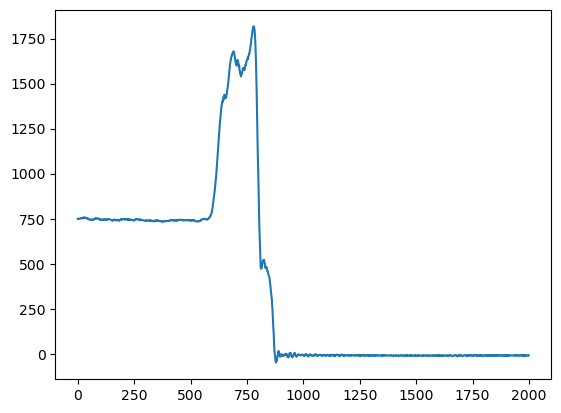

In [10]:
Plate_Force["垂直力"].plot()